## Fit a kernel to a signal with random noise, try to remove it.

- Use GPyTorch
- Eclipsing binary + Pulsation + noise
- RBF kernel
- Check that residuals are random noise

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilGPyTorch()

# Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [4]:
df = pd.read_csv("data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

In [6]:
N_samples=11300

In [7]:
X_part=X[:N_samples]
Y_part=Y[:N_samples]

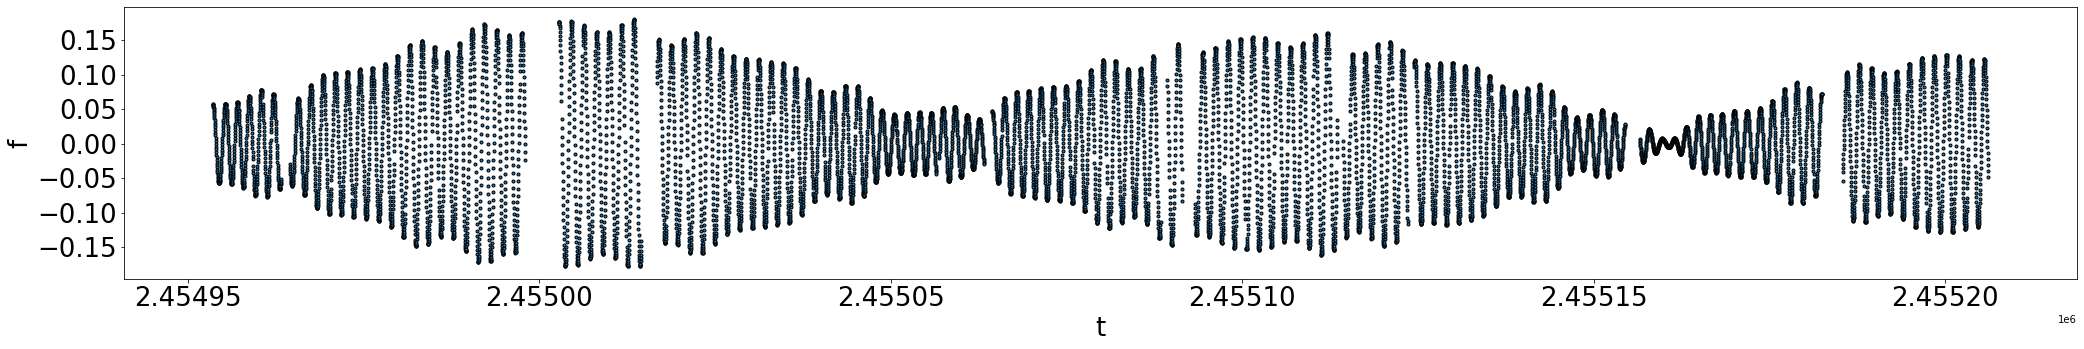

In [8]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [9]:
# normalize the data
_, _, Y_part = experiment_util.normalize_mean(Y_part)

In [10]:
# Add random uncorrelated noise to the data
N_part, YpN_part = experiment_util.generate_random_noise(Y_part)

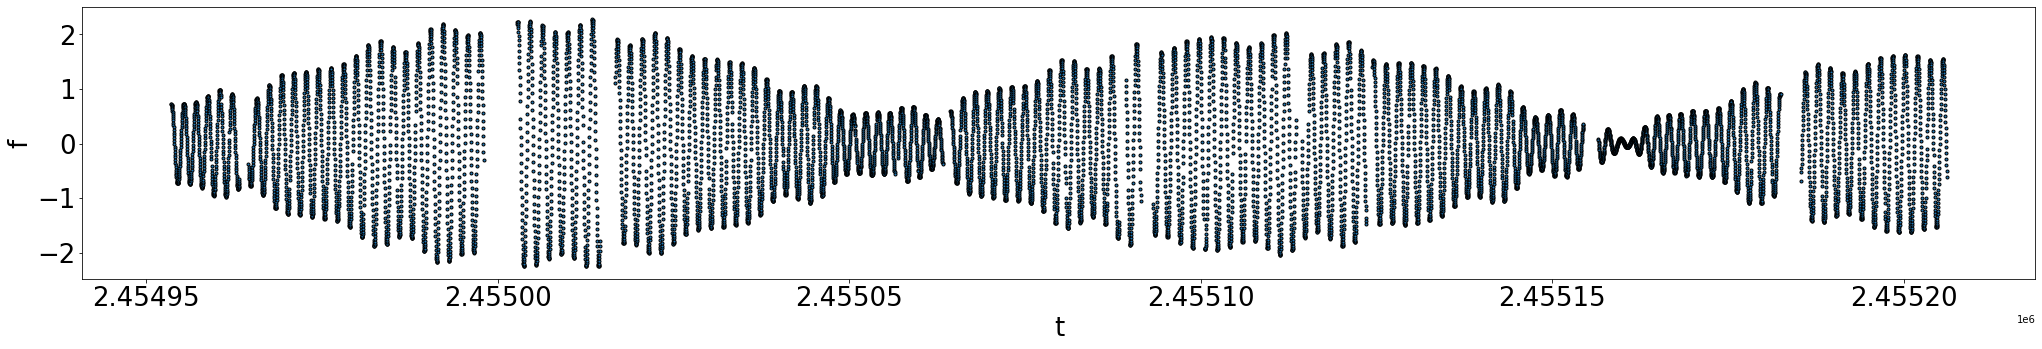

In [11]:
plotter.plot_data(X_part, Y_part)

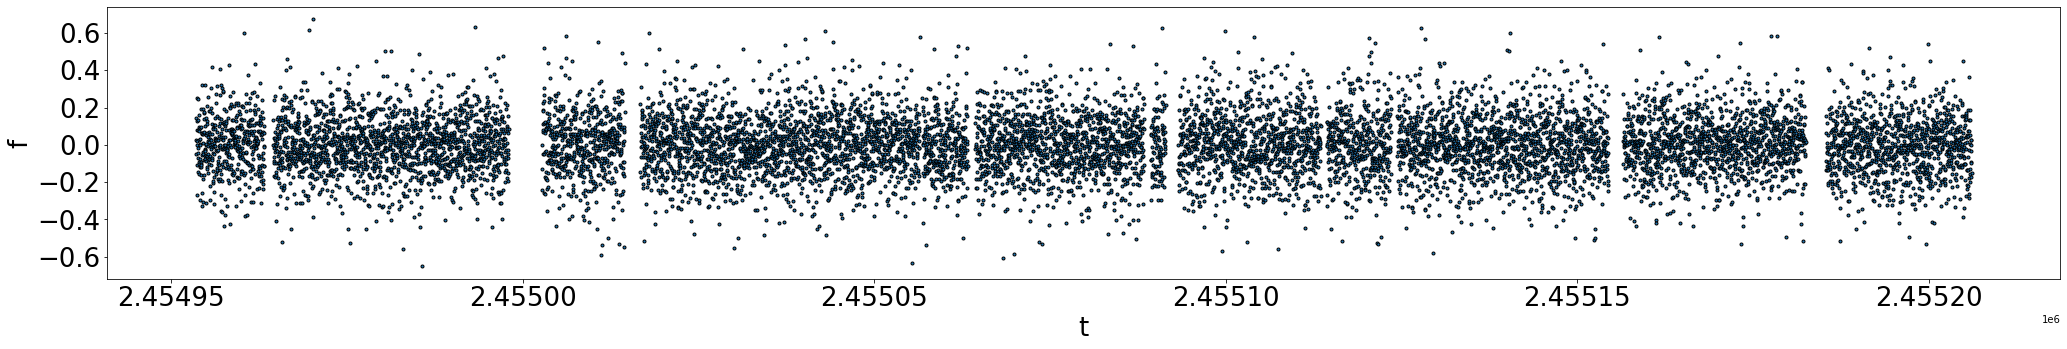

In [12]:
plotter.plot_data(X_part, N_part)

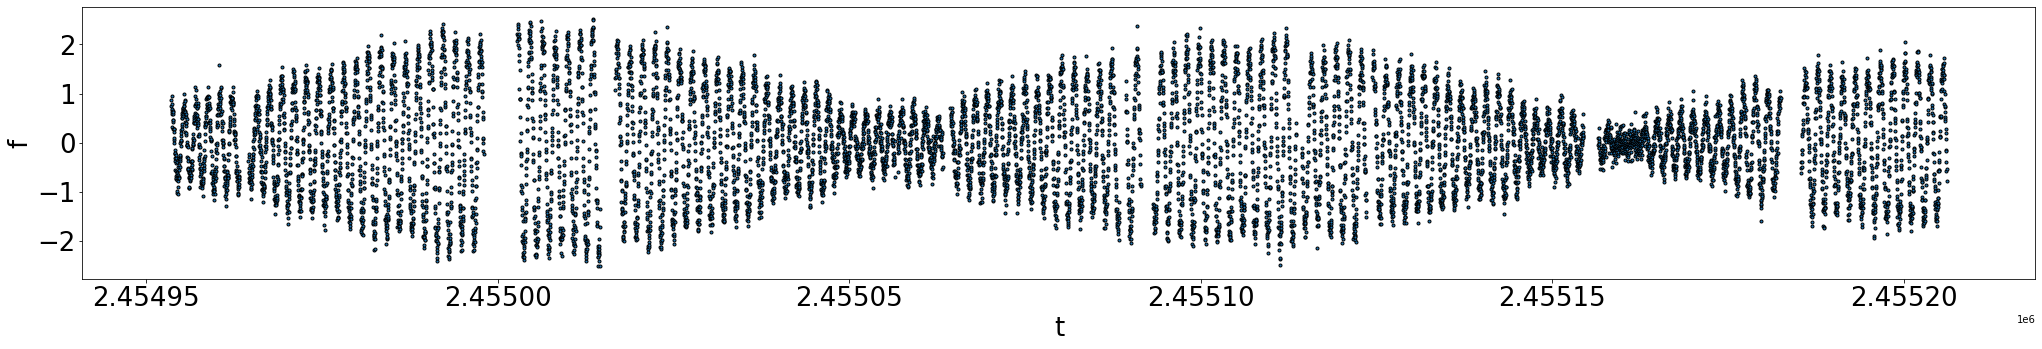

In [13]:
plotter.plot_data(X_part, YpN_part)

In [14]:
X_part=torch.tensor(X_part)
Y_part=torch.tensor(Y_part)
YpN_part=torch.tensor(YpN_part)

Move data and models to the GPU

In [15]:
if USE_CUDA:
    X_part = X_part.cuda()
    Y_part = Y_part.cuda()
    YpN_part = YpN_part.cuda()
    model = model.cuda()
    likelihood = likelihood.cuda()

In [16]:
from gpytorch.priors import NormalPrior

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # RBF kernel for the uncorrelated noise
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module.base_kernel.lengthscale=0.8

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_part, YpN_part, likelihood)

# As we are using float64 data, we need to convert our model to double
_ = model.double()
_ = likelihood.double()

In [17]:
# Test with 10, 50, 100
training_iter = 75 # normally 50 but try to get in the peaks

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer on a subset of the hyperparameters
all_params = set(model.parameters())
optimizer = torch.optim.Adam(all_params, lr=0.15)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_part)
    # Calc loss and backprop gradients
    loss = -mll(output, YpN_part)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   Lengthscale: %.3f    noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale,
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/75 - Loss: 1.055   Lengthscale: 0.800    noise: 0.693
Iter 2/75 - Loss: 0.903   Lengthscale: 0.720    noise: 0.621
Iter 3/75 - Loss: 0.795   Lengthscale: 0.649    noise: 0.554
Iter 4/75 - Loss: 0.716   Lengthscale: 0.587    noise: 0.493
Iter 5/75 - Loss: 0.647   Lengthscale: 0.536    noise: 0.437
Iter 6/75 - Loss: 0.586   Lengthscale: 0.493    noise: 0.386
Iter 7/75 - Loss: 0.531   Lengthscale: 0.458    noise: 0.340
Iter 8/75 - Loss: 0.477   Lengthscale: 0.430    noise: 0.299
Iter 9/75 - Loss: 0.420   Lengthscale: 0.406    noise: 0.261
Iter 10/75 - Loss: 0.366   Lengthscale: 0.388    noise: 0.228
Iter 11/75 - Loss: 0.310   Lengthscale: 0.373    noise: 0.199
Iter 12/75 - Loss: 0.261   Lengthscale: 0.361    noise: 0.173
Iter 13/75 - Loss: 0.208   Lengthscale: 0.353    noise: 0.151
Iter 14/75 - Loss: 0.150   Lengthscale: 0.347    noise: 0.131
Iter 15/75 - Loss: 0.102   Lengthscale: 0.344    noise: 0.113
Iter 16/75 - Loss: 0.052   Lengthscale: 0.343    noise: 0.098
Iter 17/75 - Loss

In [18]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [19]:
median_sampling_period = experiment_util.median_sampling_period(X_part)
model.covar_module.base_kernel.lengthscale / median_sampling_period

tensor([[18.7975]], dtype=torch.float64, grad_fn=<DivBackward0>)

In [20]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Y_part_pred = likelihood(model(X_part))

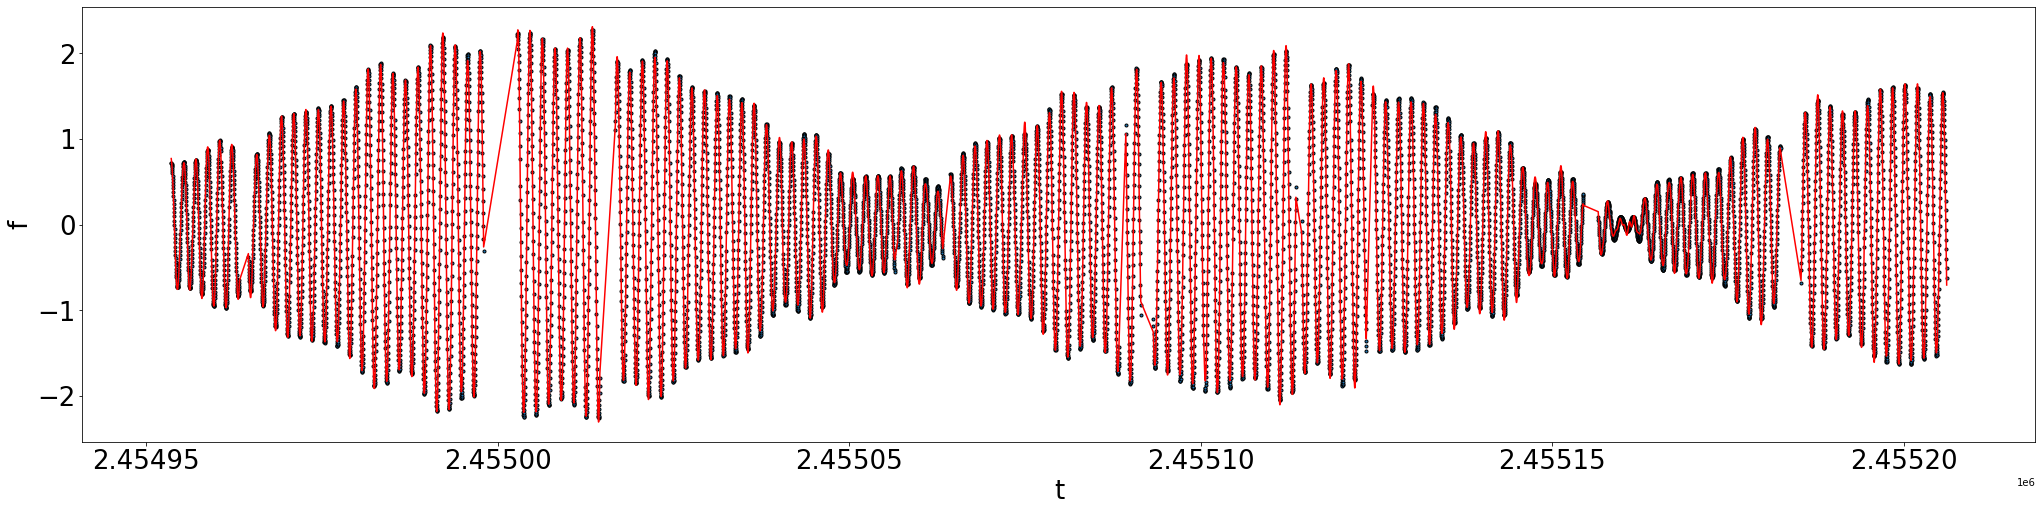

In [21]:
# Plot series with the original X positions
with torch.no_grad():
    plotter.plot_series(X_part.cpu().numpy(), Y_part.cpu().numpy(), X_part.cpu().numpy(), Y_part_pred.mean.cpu().numpy())

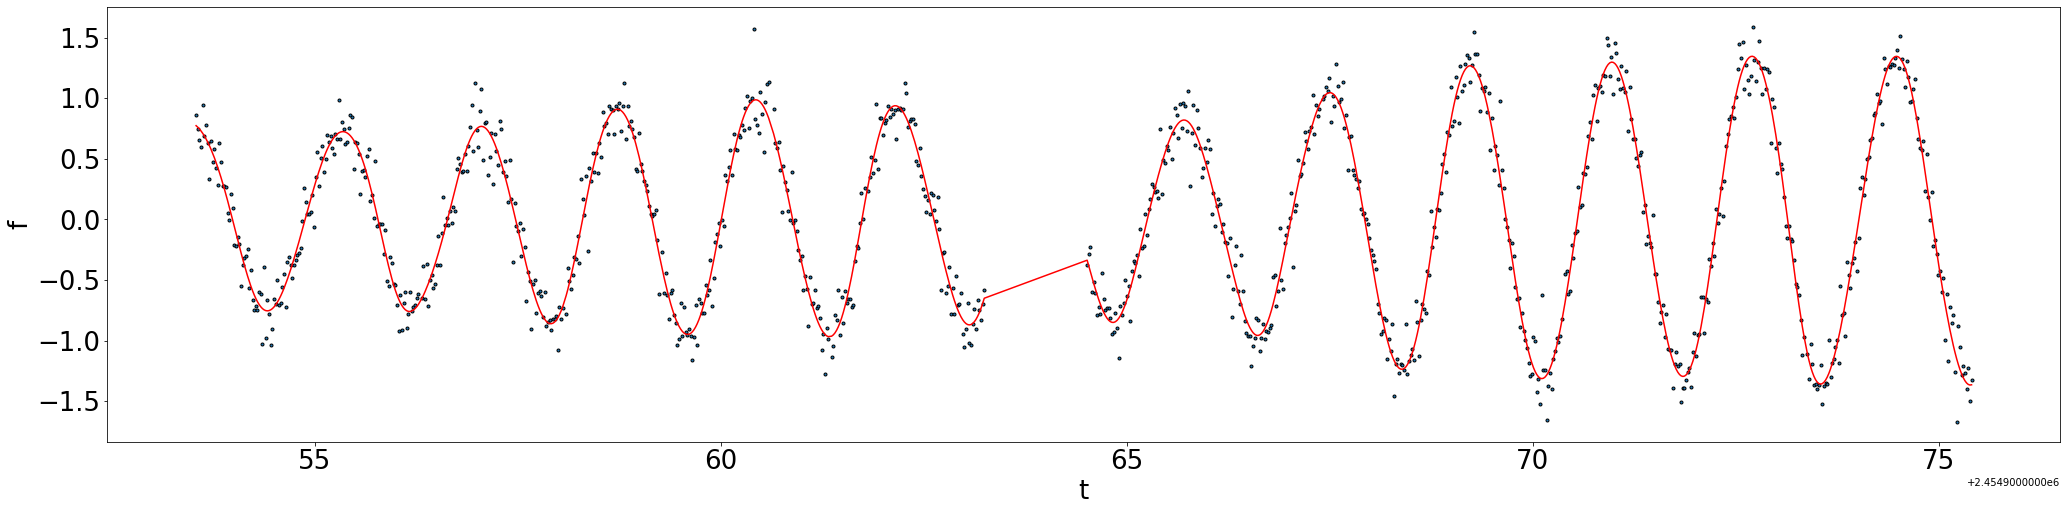

In [22]:
# Plot series with the original X positions
with torch.no_grad():
    plotter.plot_series(X_part.cpu().numpy()[0:1000], YpN_part.cpu().numpy()[0:1000], X_part.cpu().numpy()[0:1000], Y_part_pred.mean.cpu().numpy()[0:1000])

In [23]:
# Calculate the residuals on the original X positions!
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    residuals = Y_part.cpu()-Y_part_pred.mean.cpu().numpy()

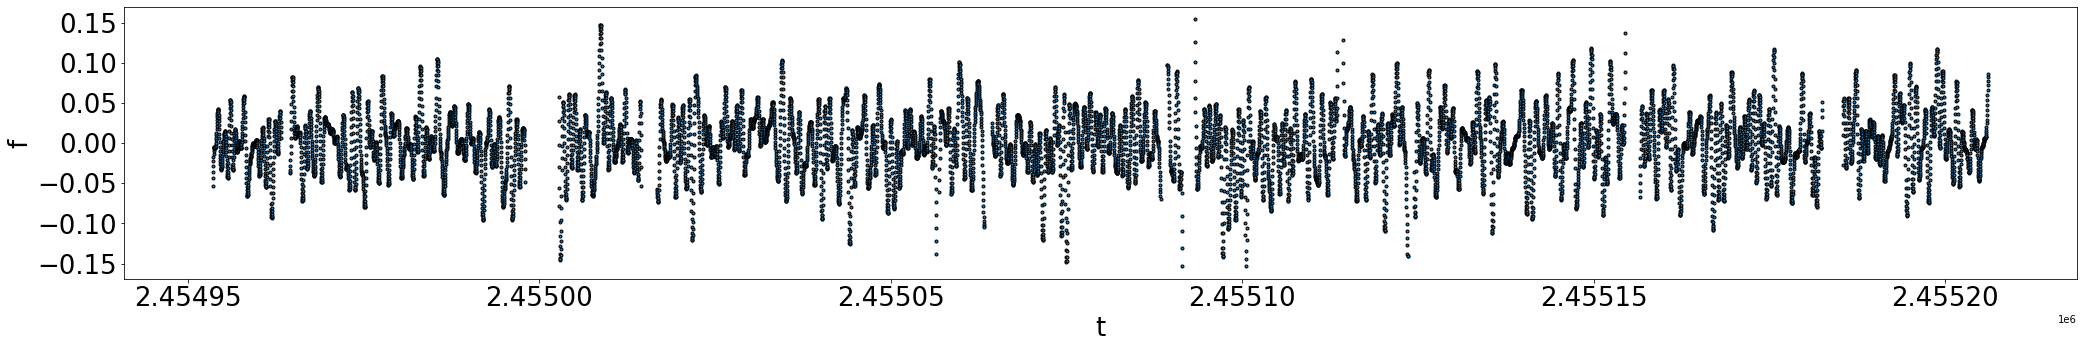

In [24]:
# Plot GP residuals
plotter.plot_data(X_part.cpu(), residuals)

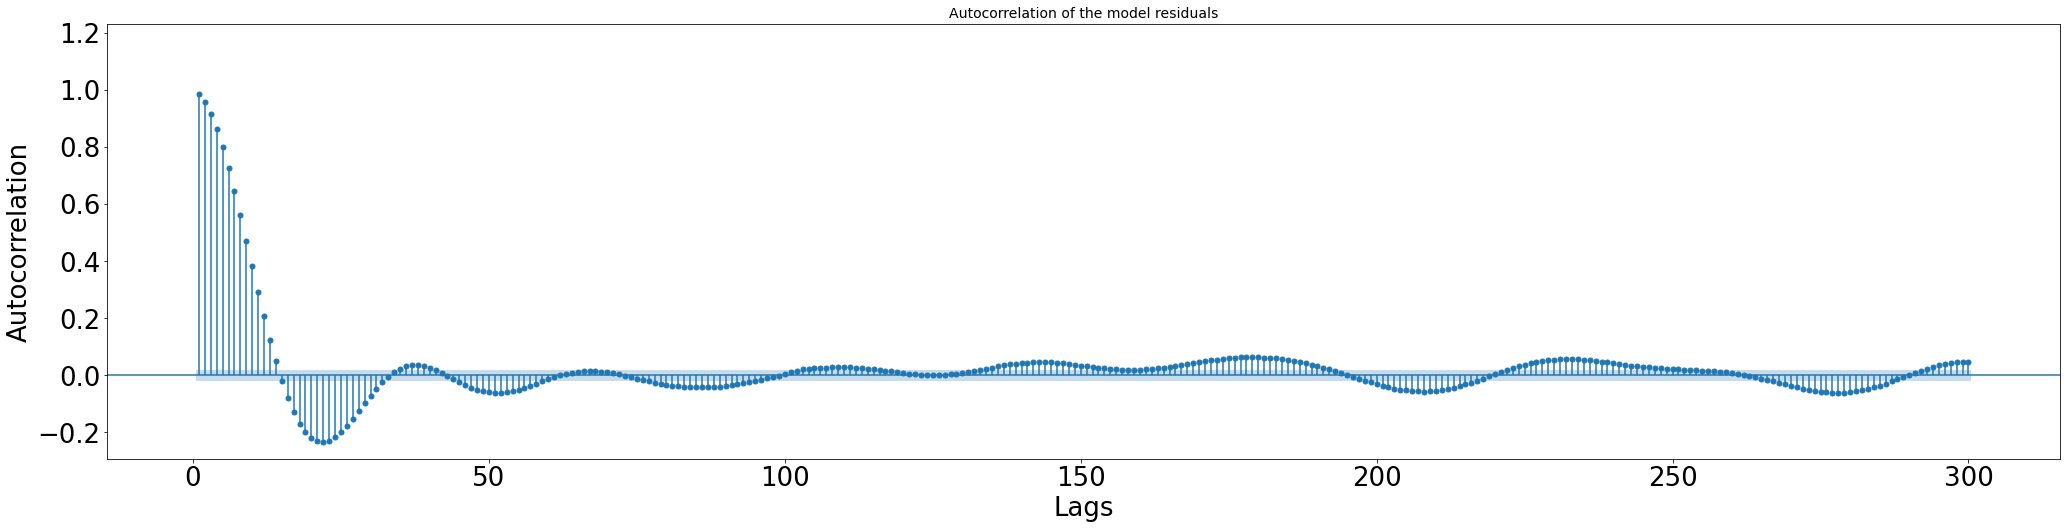

In [25]:
# Now plot the ACF of the residuals. Amplitudes should be under 0.05.
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(35, 8))
# Plot ACF
plot_acf(residuals, lags=300, alpha=1-0.95, zero=False, auto_ylims=True, bartlett_confint=False)
plt.xticks(fontsize=26), plt.yticks(fontsize=26)
plt.xlabel('Lags', fontsize=26)
plt.ylabel('Autocorrelation', fontsize=26)
plt.title('Autocorrelation of the model residuals', fontsize=14)
plt.show()

In [26]:
# The confidence interval in the plot is calculated as:
# qnorm((1 + ci)/2)/sqrt(N)
# Our CI is 0.95

In [27]:
experiment_util.calculate_error(Y_part, Y_part_pred.mean.cpu())

TimeSeriesSimilarity(correlation=0.9992190926268987, rmse=0.03951713691630446)